
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [ ]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
# import cv2
from os import walk

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
IMAGE_SIZE = 50
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 25420 # the number of images we use from each of the two classes

In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'


# num_train_samples = len(df_train)
# num_val_samples = len(df_val)
train_batch_size = 64
val_batch_size = 64


train_steps = 128
val_steps = 128

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             shear_range = 0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 40672 images belonging to 2 classes.
Found 10168 images belonging to 2 classes.
Found 10168 images belonging to 2 classes.


In [ ]:
vgg16_model = keras.applications.vgg16.VGG16(input_shape =(50,50,3) ,weights='imagenet', include_top=False)

In [ ]:
vgg16_model.trainable = False

In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import backend as K
from keras.layers import Dense,Flatten

In [ ]:
model_mod = vgg16_model.layers[-1].output
flatten = tf.keras.layers.Flatten()(model_mod)
denser = tf.keras.layers.Dense(128, activation = 'relu')(flatten)
dropout = tf.keras.layers.Dropout(0.5)(denser)
prediction = tf.keras.layers.Dense(2, activation = 'softmax')(dropout)

model2= tf.keras.Model(inputs=vgg16_model.input, outputs=prediction)

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
model2.compile(Adam(learning_rate=0.001), loss="binary_crossentropy", 
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = "modeldropout.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, 
                             save_best_only=True, mode='max')
                              
                              
callbacks_list = [checkpoint]

history = model2.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=64, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/64
128/128 [==============================] - ETA: 0s - loss: 0.6041 - accuracy: 0.6888
Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to modeldropout.h5
128/128 [==============================] - 156s 1s/step - loss: 0.6041 - accuracy: 0.6888 - val_loss: 0.5388 - val_accuracy: 0.7500
Epoch 2/64
128/128 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.7479
Epoch 00002: val_accuracy improved from 0.75000 to 0.76184, saving model to modeldropout.h5
128/128 [==============================] - 99s 775ms/step - loss: 0.5383 - accuracy: 0.7479 - val_loss: 0.5126 - val_accuracy: 0.7618
Epoch 3/64
128/128 [==============================] - ETA: 0s - loss: 0.5248 - accuracy: 0.7584
Epoch 00003: val_accuracy improved from 0.76184 to 0.76392, saving model to modeldropout.h5
128/128 [==============================] - 90s 705ms/step - loss: 0.5248 - accuracy: 0.7584 - val_loss: 0.5024 - val_accuracy: 0.7639
Epoch 4/64
128/128 [===================

In [ ]:
vgg16_model.trainable = True

In [ ]:
model2.compile(Adam(learning_rate=0.0001), loss="binary_crossentropy", 
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = "modeldropout.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, 
                             save_best_only=True, mode='max')
                              
                              
callbacks_list = [checkpoint]

history = model2.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=64, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/64
128/128 [==============================] - ETA: 0s - loss: 0.5327 - accuracy: 0.7513
Epoch 00001: val_accuracy improved from -inf to 0.81018, saving model to modeldropout.h5
128/128 [==============================] - 333s 3s/step - loss: 0.5327 - accuracy: 0.7513 - val_loss: 0.4298 - val_accuracy: 0.8102
Epoch 2/64
128/128 [==============================] - ETA: 0s - loss: 0.4350 - accuracy: 0.8125
Epoch 00002: val_accuracy did not improve from 0.81018
128/128 [==============================] - 330s 3s/step - loss: 0.4350 - accuracy: 0.8125 - val_loss: 0.4386 - val_accuracy: 0.8085
Epoch 3/64
128/128 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8220
Epoch 00003: val_accuracy improved from 0.81018 to 0.81641, saving model to modeldropout.h5
128/128 [==============================] - 324s 3s/step - loss: 0.4266 - accuracy: 0.8220 - val_loss: 0.4031 - val_accuracy: 0.8164
Epoch 4/64
128/128 [==============================] - ETA: 0s - loss: 0.4047 - a

In [ ]:
model2.save("model_vgg16_trainable.h5")

In [ ]:
# get the metric names so we can use evaulate_generator
model2.metrics_names

['loss', 'accuracy']

In [ ]:
model2.save_weights("modeldropout.h5")

In [ ]:
# Here the best epoch will be used.

model2.load_weights('modeldropout.h5')

# val_loss, val_acc = \
# model2.evaluate_generator(test_gen, 
#                         steps=len(df_val))
val_loss, val_accuracy = \
model2.evaluate_generator(test_gen, 
                        steps=10168)
print('val_loss:', val_loss)
print('val_acc:', val_accuracy)

C:\Users\user\AppData\Local\Temp/ipykernel_17536/1901143380.py:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model2.evaluate_generator(test_gen,


val_loss: 0.32591432332992554
val_acc: 0.8638867139816284


<Figure size 432x288 with 0 Axes>

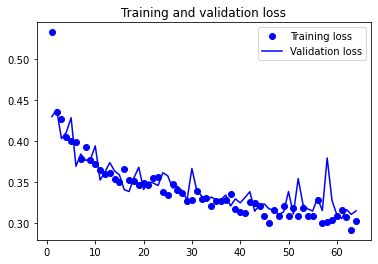

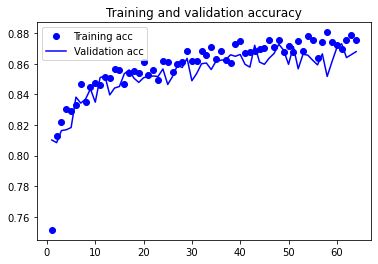

<Figure size 432x288 with 0 Axes>

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [ ]:
# make a prediction
predictions = model2.predict_generator(test_gen, steps=10168, verbose=1)

    1/10168 [..............................] - ETA: 27:39

C:\Users\user\AppData\Local\Temp/ipykernel_17536/1072763360.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model2.predict_generator(test_gen, steps=10168, verbose=1)


10168/10168 [==============================] - 164s 16ms/step


In [ ]:
predictions.shape

(10168, 2)

In [ ]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [ ]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])

df_preds.head()

,no_idc,has_idc
0,0.231458,0.768542
1,0.967258,0.032742
2,0.126188,0.873812
3,0.999995,0.000005
4,0.999332,0.000668


In [ ]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9353506449632021

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
test_labels.shape

(10168,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_idc', 'has_idc']

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)


              precision    recall  f1-score   support

      no_idc       0.87      0.84      0.86      5084
     has_idc       0.85      0.88      0.86      5084

    accuracy                           0.86     10168
   macro avg       0.86      0.86      0.86     10168
weighted avg       0.86      0.86      0.86     10168



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


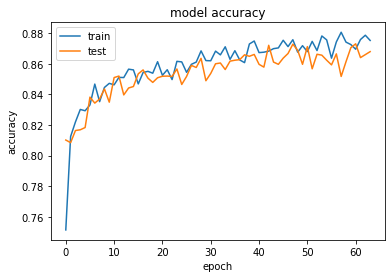

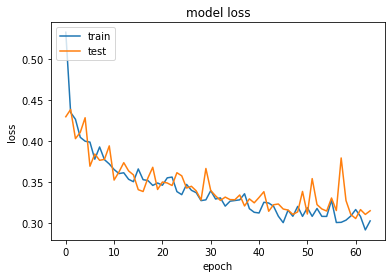

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import seaborn as sn

In [ ]:
cm = confusion_matrix(y_true, y_pred_binary)

Text(0.5, 15.0, 'Predicted label')

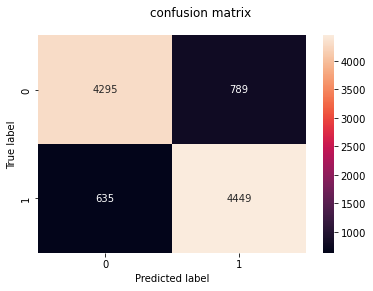

In [ ]:
fig = plt.figure()
fig.suptitle('confusion matrix')
sn.heatmap(cm, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
balanced_acc=( (cm[0,0]/(cm[0,0]+cm[0,1])) + (cm[1,1]/(cm[1,0]+cm[1,1])) )/2
# F1-score = 2 x (Recall x Precision) / (Recall + Precision)
# Recall = TP/(TP+FN))
# Precision = TP/(TP+FP)
f1_score=( 2
          *
          #recall * precission
          ((cm[1,1]/(cm[1,1]+cm[1,0])) * (cm[1,1]/(cm[1,1]+cm[0,1])))
          /
          #recall + precission
          ((cm[1,1]/(cm[1,1]+cm[1,0])) + (cm[1,1]/(cm[1,1]+cm[0,1])))
)
print(balanced_acc)
print(f1_score)

0.8599527930763179
0.862042239875993
